# Experiment 4.1: Testing the BMT with short, unclipped videos (ActivityNet Captions Dataset)

The aim of this experiment is to evaluate whether the BMT yields an amount of captions consistent with the amount of events found by human annotators. As discussed earlier, the number of annotations in the dataset is subject to the criteria the annotator uses to determine what an event is. This experiment will help us understand the influence of the implicit criteria from annotators in the dataset on the proposal generator module from the BMT. The results will be referenced in further experiments to compare our solution to the original BMT.

## 1. Environment
In the following cell, change assign `WD` the path to the BMT-Clipping repository. If you want to use the original BMT repository, you need to make the same modifications we made to the [`single_video_prediction.py`](https://github.com/oscarmires/BMT-Clipping/blob/master/sample/single_video_prediction.py) file.

Additionally, assign the path to your environments directory (e.g. where conda stores all directories) to the `ENVS_PATH` variable.

In [14]:
# Working directory (it must be the repository's root directory)
WD = '/home/A01630791/BMT-Clipping'
%cd $WD

# Environments directory (e.g. anaconda3/envs)
ENVS_PATH = '/home/A01630791/anaconda3/envs'

/home/A01630791/BMT-Clipping


In [ ]:
# Environment
## feature extraction (run directly in terminal if the notebook can't execute)
!conda env create -f ./submodules/video_features/conda_env_i3d.yml
!conda env create -f ./submodules/video_features/conda_env_vggish.yml
## captioning model (run directly in terminal if the notebook can't execute)
!conda env create -f ./conda_env.yml
## spacy language model (use the path to your 'bmt' environment instead)
!$ENVS_PATH/bmt/bin/python -m spacy download en

In [3]:
# (Optional) Install additional libraries in environment (run directly in terminal if the notebook can't execute)
!conda install pytube
!conda install numpy
!conda install matplotlib

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [111]:
import json, re, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytube import YouTube

## 2. Importing the dataset
In this part, we use the ActivityNet Captions dataset available at https://cs.stanford.edu/people/ranjaykrishna/densevid/.
Download the dataset to your filesystem before executing the following cells.

### 2.1 Train set
The train set will be necessary for some preliminary analysis of the data the BMT was trained on.

In [16]:
# Replace the value of the following variable with the path to the dataset in your fs.
ANETC_PATH = '/home/A01630791/bmt_clipping_experiments/ActivityNet_Captions'

In [17]:
# Open the file as a JSON object
with open(f'{ANETC_PATH}/train.json', 'r') as f:
    activitynet_train = json.load(f)

In [18]:
# (Optional) Test the above cell by printing a sample.
print('sample:', activitynet_train['v_QOlSCBRmfWY'])
print('\nNumber of samples: ', len(activitynet_train))

sample: {'duration': 82.73, 'timestamps': [[0.83, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', ' The girl dances around the room while the camera captures her movements.', ' She continues dancing around the room and ends by laying on the floor.']}

Number of samples:  10009


### 2.2 Validation set
The validation set no. 1 from ActivityNet Captions will be used to feed the BMT in this experiment. We prefer a test dataset. We cannot use it, however, because it doesn't include annotations, hence our choice for a validation subset.

In [19]:
# Open the file as a JSON object
with open(f'{ANETC_PATH}/val_1.json', 'r') as f:
    activitynet_val = json.load(f)

In [20]:
# (Optional) Test the above cell printing a sample.
print('sample:', activitynet_val['v_uqiMw7tQ1Cc'])
print('\nNumber of samples: ', len(activitynet_val))

sample: {'duration': 55.15, 'timestamps': [[0.28, 55.15], [13.79, 54.32]], 'sentences': ['A weight lifting tutorial is given.', '  The coach helps the guy in red with the proper body placement and lifting technique.']}

Number of samples:  4917


## 3. Preparing and pre-analyzing the data

We make this previous analysis to have general view of the data in ActivityNet Captions.
First, we need to convert the data to an array, so it is easier to work with.
The following cell traverses each element in the JSON dataset to reformat them into an array.

In [21]:
# Convert 'activitynet_test' to an array of dictionaries
activitynet_train_list = []

for key in activitynet_train.keys():
    obj = activitynet_train[key]
    obj['video_id'] = key[2:]
    obj['dataset_key'] = key
    activitynet_train_list.append(obj)
    
print('sample:', activitynet_train_list[0])
print('\narr length:', len(activitynet_train_list))

sample: {'duration': 82.73, 'timestamps': [[0.83, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', ' The girl dances around the room while the camera captures her movements.', ' She continues dancing around the room and ends by laying on the floor.'], 'video_id': 'QOlSCBRmfWY', 'dataset_key': 'v_QOlSCBRmfWY'}

arr length: 10009


In [22]:
# Convert 'activitynet_val' to an array of dictionaries
activitynet_val_list = []

for key in activitynet_val.keys():
    obj = activitynet_val[key]
    obj['video_id'] = key[2:]
    obj['dataset_key'] = key
    activitynet_val_list.append(obj)
    
print('sample:', activitynet_val_list[0])
print('\narr length:', len(activitynet_val_list))

sample: {'duration': 55.15, 'timestamps': [[0.28, 55.15], [13.79, 54.32]], 'sentences': ['A weight lifting tutorial is given.', '  The coach helps the guy in red with the proper body placement and lifting technique.'], 'video_id': 'uqiMw7tQ1Cc', 'dataset_key': 'v_uqiMw7tQ1Cc'}

arr length: 4917


### 3.1 Video duration vs. annotations
In this part, we want to see the distribution of annotations over different video durations.

The following cell plots the video duration vs. no. of annotations in the train set.

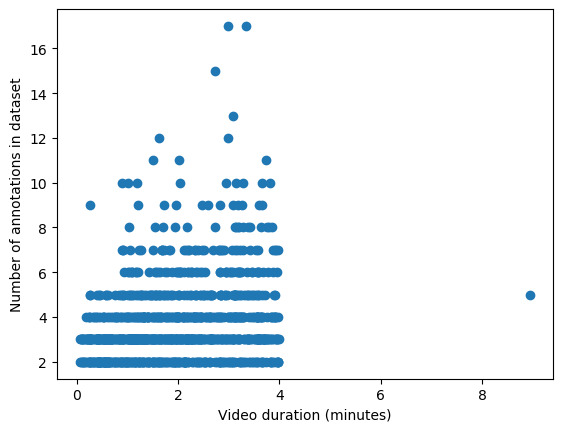

In [23]:
# activitynet_train_sorted_duration = sorted(activitynet_train_list, key=lambda i: i['duration'])

# Plot
x = [sample['duration'] / 60 for sample in activitynet_train_list][:1100]
y = [len(sample['sentences']) for sample in activitynet_train_list][:1100]

plt.scatter(x, y)

plt.xlabel("Video duration (minutes)")
plt.ylabel("Number of annotations in dataset")

# Save and show
#    Replace the following variable with the path used to save the plot
PLOT_SAVE_PATH = '/home/A01630791/bmt_clipping_experiments/Output_4_1/'

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_a.png', dpi=300)
plt.show()

The following cell plots the video duration vs. no. of annotations in the validation set.

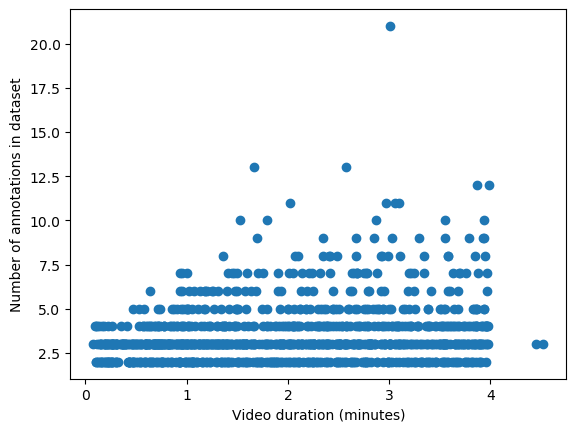

In [90]:
# activitynet_val_sorted_duration = sorted(activitynet_val_list, key=lambda i: i['duration'])

# Plot
x1 = [sample['duration'] / 60 for sample in activitynet_val_list][:601]
y1 = [len(sample['sentences']) for sample in activitynet_val_list][:601]

plt.scatter(x, y)

plt.xlabel("Video duration (minutes)")
plt.ylabel("Number of annotations in dataset")

# Save and show
#    Replace the following variable with the path used to save the plot
PLOT_SAVE_PATH = '/home/A01630791/bmt_clipping_experiments/Output_4_1/'

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_b.png', dpi=300)
plt.show()

It is expected that a longer video is given a greater number of annotations. This expectation is fulfilled for videos with a length between zero and four minutes, where some of the samples approaching a length of four minutes reach the greatest amount of annotations. Nevertheless, some others have as few annotations as those which length approaches zero minutes. The dataset does not contain enough samples with a duration greater than four minutes to reach a conclusion about them. We can think of many reasons the lack of annotations for videos longer than four minutes. For instance, the annotator might have found that the video did not have more relevant events or, maybe, the the annotator didn't have enough time to give attention to detail.

As mention before, we wish to understand the influence of implicit criteria from annotators in the dataset on the proposal generator module from the BMT. As part of this experiment, we will feed the same dataset to the BMT to generate captions to compare the patterns we see in the previous plots to the patterns we will find in duration vs. generated captions plots.

## 4. Execution
In this part, we execute the BMT model to generate captions for each of the samples in the `activitynet_val` set. We will not need the `activitynet_test` set anymore. The results will then be taken to obtain a 'Duration vs. number of generated captions' chart and the following metrics: 
- Captions Per Minute (CPM): the number of captions the BMT generates after running a single video, divided by the duration of the video in minutes.
- Ground-truths Per Minute (GPM): the number of ground-truths (human-consulted textual event descriptions) the dataset provides for each video to train the model, divided by the duration of the video in minutes.
- Caption-to-ground-truth correlation coefficient (_r_): the correlation coefficient between CPM and GPM as implemented by NumPy.


### 4.1 Preparation
Assign the path where you would like to create the output file. We name this file `4_1_bmt_captions.json`.

Additionally, create a directory in your filesystem to temporarily store the YouTube videos. Assign `ANETC_VIDEOS_PATH` the path to this directory.

In [25]:
# Create output file
OUTPUT_PATH = '/home/A01630791/bmt_clipping_experiments/Output_4_1'

with open(f'{OUTPUT_PATH}/4_1_bmt_captions.json', "w") as f:
  f.write("[]")

# Video directory (path to your)
ANETC_VIDEOS_PATH = '/home/A01630791/bmt_clipping_experiments/ActivityNet_Captions_val_set_videos'

### 4.2 BMT installation
Run the following cells to prepare the environment for BMT.

In [26]:
# Libraries
import os
from pathlib import Path
from sample.single_video_prediction import get_video_duration

In [ ]:
# Download BMT Checkpoints

!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/glove.840B.300d.zip
!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/best_cap_model.pt
!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/best_prop_model.pt
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt

!mkdir .vector_cache
!mv glove.840B.300d.zip ./.vector_cache/
!mv best_cap_model.pt ./sample/
!mv best_prop_model.pt ./sample/
!mv vggish_model.ckpt ./submodules/video_features/models/vggish/checkpoints/

In [ ]:
# captioning parameters
MAX_PROP_PER_VIDEO = 100
NMS_TIOU_THRESHOLD = 0.4

# checkpoint paths
PROPOSAL_CKPT = f'{WD}/sample/best_prop_model.pt'
CAPTIONING_CKPT = f'{WD}/sample/best_cap_model.pt'

# execution metadata
exec_md = {
    'not_found_videos': [],
    'current_sample_num': 1,
    'total_samples': len(activitynet_val_list)
}

for sample in activitynet_val_list:
    
    try: 
        # Step 1: Download the video
        link = "https://www.youtube.com/watch?v=" + sample['video_id']
        yt = YouTube(link) 
        
        filename = re.findall("[^=]+$", link)[0] + '.mp4'
        stream = yt.streams.get_highest_resolution()
        stream.download(output_path=ANETC_VIDEOS_PATH, filename=filename)
        print('Sample download complete.')
        
        
        # Step 2: Extract visual and audio features

        ## Prepare complementary paths
        video_id = sample['video_id']
        MY_VIDEO_PATH = f'{ANETC_VIDEOS_PATH}/{video_id}.mp4'

        VIDEO_DURATION = get_video_duration(MY_VIDEO_PATH)

        FEATURES_CACHE_PATH = f'{WD}/tmp/'
        FEATURES_PATH_STUB = os.path.join(FEATURES_CACHE_PATH, Path(MY_VIDEO_PATH).stem)
        FEATURE_PATH_VGGISH = f'{FEATURES_PATH_STUB}_vggish.npy'
        FEATURE_PATH_RGB = f'{FEATURES_PATH_STUB}_rgb.npy'
        FEATURE_PATH_FLOW = f'{FEATURES_PATH_STUB}_flow.npy'
        
        # FEATURE_PATH_VGGISH = '/BMT/data/vggish_npy/' + sample['dataset_key'] + '.npy'
        # FEATURE_PATH_RGB = '/BMT/data/i3d_25fps_stack64step64_2stream_npy/' + sample['dataset_key'] + '_rgb.npy'
        # FEATURE_PATH_FLOW = '/BMT/data/i3d_25fps_stack64step64_2stream_npy/' + sample['dataset_key'] + '_flow.npy'    


        ## Extract I3D features
        print('Extracting I3D features.')
        !cd ./submodules/video_features && $ENVS_PATH/i3d/bin/python main.py \
          --feature_type i3d \
          --on_extraction save_numpy \
          --device_ids 0 \
          --extraction_fps 25 \
          --video_paths $MY_VIDEO_PATH \
          --output_path $FEATURES_CACHE_PATH

        print('Extracting VGGish features.')
        ## Extract VGGish features (audio)
        !cd ./submodules/video_features && $ENVS_PATH/vggish/bin/python main.py \
          --feature_type vggish \
          --on_extraction save_numpy \
          --device_ids 0 \
          --video_paths $MY_VIDEO_PATH \
          --output_path $FEATURES_CACHE_PATH


        # Step 3: Captioning
        print('Generating caption.')

        ## Run single video prediction
        !$ENVS_PATH/bmt/bin/python ./sample/single_video_prediction.py \
          --prop_generator_model_path $PROPOSAL_CKPT \
          --pretrained_cap_model_path $CAPTIONING_CKPT \
          --vggish_features_path $FEATURE_PATH_VGGISH \
          --rgb_features_path $FEATURE_PATH_RGB \
          --flow_features_path $FEATURE_PATH_FLOW \
          --duration_in_secs $VIDEO_DURATION \
          --device_id 0 \
          --max_prop_per_vid $MAX_PROP_PER_VIDEO \
          --nms_tiou_thresh $NMS_TIOU_THRESHOLD \
          --video_id $video_id \
          --output_path $OUTPUT_PATH/4_1_bmt_captions.json
        
        
        # Step 4: Delete video to free space
        os.remove(MY_VIDEO_PATH)
        print('Sample deleted')
        
    except: 
        print("Error: can't instantiate YouTube object.") 
        exec_md['not_found_videos'].append(sample['video_id'])
        
    curr_sample = exec_md['current_sample_num']
    exec_md['current_sample_num'] += 1
    total_samples = exec_md['total_samples']
    print(f'\n ***** Processed {curr_sample}/{total_samples} samples. *****\n')
    

print('Execution completed.') 
print(exec_md)
print('YouTube not found videos:', len(exec_md['not_found_videos']))

In [12]:
# Copy and rename the output file to save permanently (uncomment and run next line)
### !cp $OUTPUT_PATH/4_1_bmt_captions.json $OUTPUT_PATH/4_1_bmt_captions_save.json

### 4.3 Analysis

To analyze the results, open the output file from last job in the next cell.

In [190]:
with open('/home/A01630791/bmt_clipping_experiments/Output_4_1/4_1_bmt_captions_save.json', 'r') as f:
    bmt_results = np.array(json.load(f))

print('Total processed samples:', len(bmt_results))

Total processed samples: 601


Next, we obtain a plot displaying video duration in minutes over the horizontal axis and number of generated captions over the vertical axis. We wish to compare the pattern with the one we observed in 3.1. In other words, observe the effect the amount of annotations in training has on the amount of generated captions.

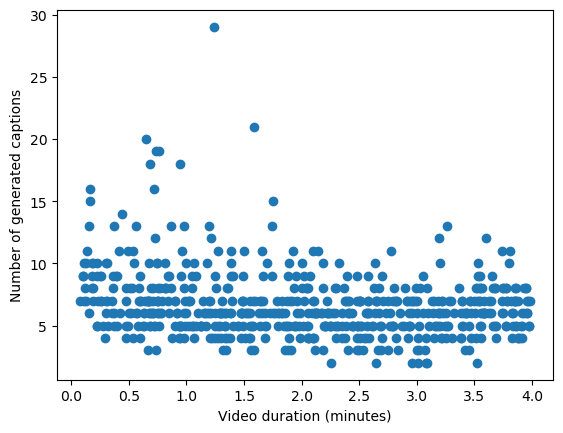

In [192]:
x2 = [sample['duration'] / 60 for sample in bmt_results]
y2 = [len(sample['captions']) for sample in bmt_results]

plt.scatter(x2, y2)

plt.xlabel("Video duration (minutes)")
plt.ylabel("Number of generated captions")

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_c.png', dpi=300)
plt.show()

We don't recognize the same pattern we had in 3.1, where longer videos are prone to have more annotations than shorter videos. In contrast, we observe that most of the videos are given, by the BMT, an amount of captions within a similar range (about 3 to 12 captions) regardless of the duration of the video. In order to see this more clearly, we compute trend lines for both the validation dataset and the generated captions dataset in the following cell.

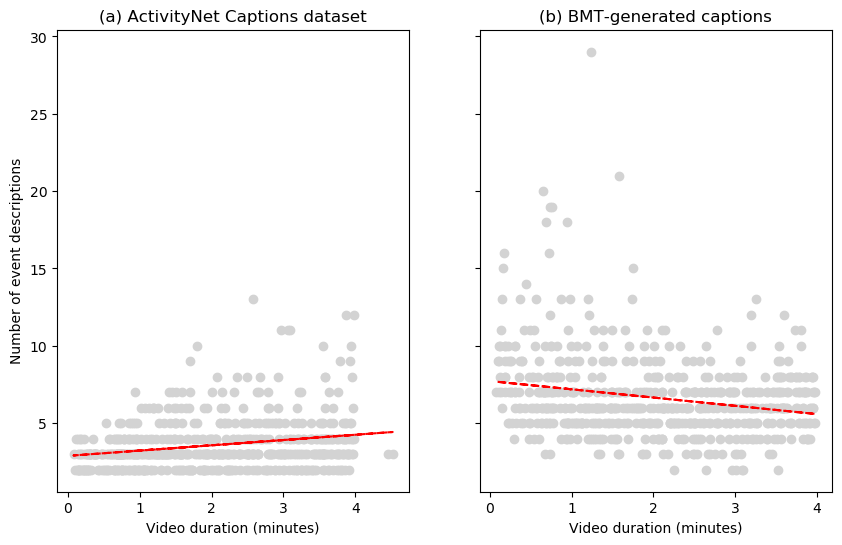

In [193]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
f.set_figheight(6)

# Left
ax1.scatter(x1, y1, color="lightgray")
ax1.set_title('(a) ActivityNet Captions dataset')
ax1.set_xlabel('Video duration (minutes)')
ax1.set_ylabel('Number of event descriptions')
z = np.polyfit(x1, y1, 1)
p = np.poly1d(z)
ax1.plot(x1, p(x1), "r--")

# Right
ax2.scatter(x2, y2, color="lightgray")
ax2.set_title('(b) BMT-generated captions')
ax2.set_xlabel('Video duration (minutes)')
z = np.polyfit(x2, y2, 1)
p = np.poly1d(z)
ax2.plot(x2, p(x2), "r--")

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_d.png', dpi=300)

We make two observations from this results: (1) the BMT does not learn to determine the number of events in function of video duration, and (2) the BMT generates a similar amount of event captions for most videos regardless of their duration.

In the next cell we compute some other measurements that will as well help us understand the influence of human criteria for annotations in the event proposal generator from BMT:
- Average number of generated captions.
- Captions Per Minute (CPM): the number of captions the BMT generates after running a single video, divided by the duration of the video in minutes.
- Ground-truths Per Minute (GPM): the number of ground-truths (human-consulted textual event descriptions) the dataset provides for each video to train the model, divided by the duration of the video in minutes.
- Caption-to-ground-truth correlation coefficient (r): the correlation coefficient between CP M and GPM as implemented by NumPy.

**Average number of generated captions**

In [76]:
num_gcaptions = np.array([len(sample['captions']) for sample in bmt_results])
avg_num_gcaptions = np.average(num_gcaptions)
avg_num_gcaptions

6.643926788685524

Surprisingly, the BMT duplicates the average amount of captions provided by the ActivityNet Captions dataset.

**GPM, CPM**

The following cells will produce a GPM vs. CPM plot to help visualize the relationship between human annotations and generated captions independent of video duration.

In [197]:
"""
We select all elements in ActivityNet Captions that have corresponding elements in BMT-generated captions
(This is becuase we didn't feed the BMT with all samples from ActivityNet Captions)
"""
# 1. Obtain DataFrame (assign your path to next variable)

## For GPM (replace with your path):
path_to_activitynet_val = f'{ANETC_PATH}/val_1.json'
anetc_val_df = pd.read_json(path_to_activitynet_val, orient='index')

## For CPM (replace with your path):
path_to_bmt_results = '/home/A01630791/bmt_clipping_experiments/Output_4_1/4_1_bmt_captions_save.json'
bmt_results_df = pd.read_json(path_to_bmt_results, orient='records')
bmt_results_df['video_id'] = 'v_' + bmt_results_df['video_id']
bmt_results_df.set_index('video_id', inplace=True)

In [198]:
# 2. Summary functions and statistics

## Add column with number of captions
##  (Note: we use the terms 'sentences', and 'captions' interchangeably here)
anetc_val_df['number_captions'] = anetc_val_df.sentences.map(lambda c: len(c))
bmt_results_df['number_captions'] = bmt_results_df.captions.map(lambda c: len(c))

## Add column with GPM
anetc_val_df['gpm'] = anetc_val_df.number_captions / anetc_val_df.duration

## Add column with CPM
bmt_results_df['cpm'] = bmt_results_df.number_captions / bmt_results_df.duration

In [199]:
# 3. Filter (keep only elements in ActivityNet Captions that appear in BMT-generated captions)
anetc_filtered_df = anetc_val_df.loc[bmt_results_df.index]
anetc_filtered_df.shape

(601, 5)

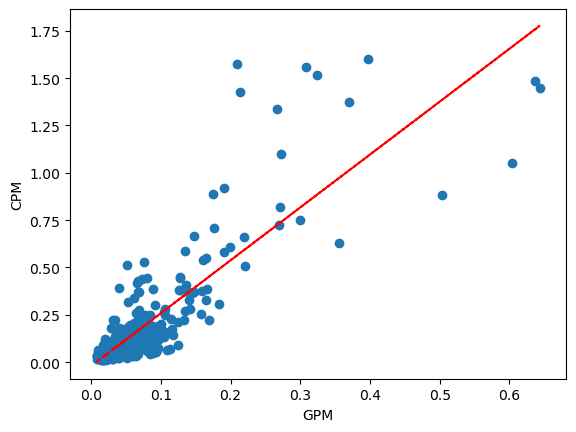

In [204]:
# 4. Plot
# Graph: ground vs. unclippd cpm relationship
x = anetc_filtered_df.gpm
y = bmt_results_df.cpm

plt.scatter(x, y)

plt.xlabel("GPM")
plt.ylabel("CPM")

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_e.png', dpi=300)
plt.show()

**Caption-to-ground-truth correlation coefficient (r)**

In [201]:
r = y.corr(x)
r

0.8624610041909555

We observe that there is a strong correlation (`r = 0.86`) between CPM and GPM. This may be an indicator that the BMT learns to detect certain variety of events for videos containing a specific set of audio/visual features that would not get detected in videos with other features.